# Baby Names

## Intro

### Download and Split Dataset

In [ ]:
import os
import pandas as pd
import random


def extract_names() -> list[str]:
    fURL = "https://www.cs.cmu.edu/Groups/AI/util/areas/nlp/corpora/names/female.txt"
    mURL = "https://www.cs.cmu.edu/Groups/AI/util/areas/nlp/corpora/names/male.txt"

    # Read text files
    f = pd.read_csv(fURL, header=None)[5:]
    m = pd.read_csv(mURL, header=None)[5:]

    # Concatenate and return names
    return f[0].tolist() + m[0].tolist()


def save_train_test_split(path: str, ratio: float) -> None:
    names = list(set(extract_names()))

    random.shuffle(names)

    os.makedirs(path, exist_ok=True)

    train_split = sorted(names[: int(len(names) * ratio)])
    test_split = sorted(names[int(len(names) * ratio) :])

    with open(path + "/train.txt", "w") as f:
        f.write("\n".join(train_split).encode("ascii", errors="ignore").decode("ascii").lower())

    with open(path + "/test.txt", "w") as f:
        f.write("\n".join(test_split).encode("ascii", errors="ignore").decode("ascii").lower())


names = extract_names()
save_train_test_split("blog/4-names/data", 0.8)

In [15]:
import random

In [1]:
# Train and test split
with open("blog/4-names/data/train.txt") as f:
    train_names = f.read().split("\n")

with open("blog/4-names/data/test.txt") as f:
    test_names = f.read().split("\n")

### Basic Data Viz

In [2]:
print(f"Train: {len(train_names)}")
print(f"Test: {len(test_names)}")
print(f"Training names: {train_names[:5]}")
print(f"Test names: {test_names[:5]}")

Train: 6063
Test: 1516
Training names: ['aamir', 'aaron', 'abagael', 'abagail', 'abbe']
Test names: ['abbey', 'abdul', 'abra', 'ace', 'adams']


In [3]:
vocab = list(sorted(set("".join(train_names))))
print(f"Vocab: {vocab}")
print(f"Vocab size: {len(vocab)}")

Vocab: [' ', "'", '-', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Vocab size: 29


#### Letter Pairings

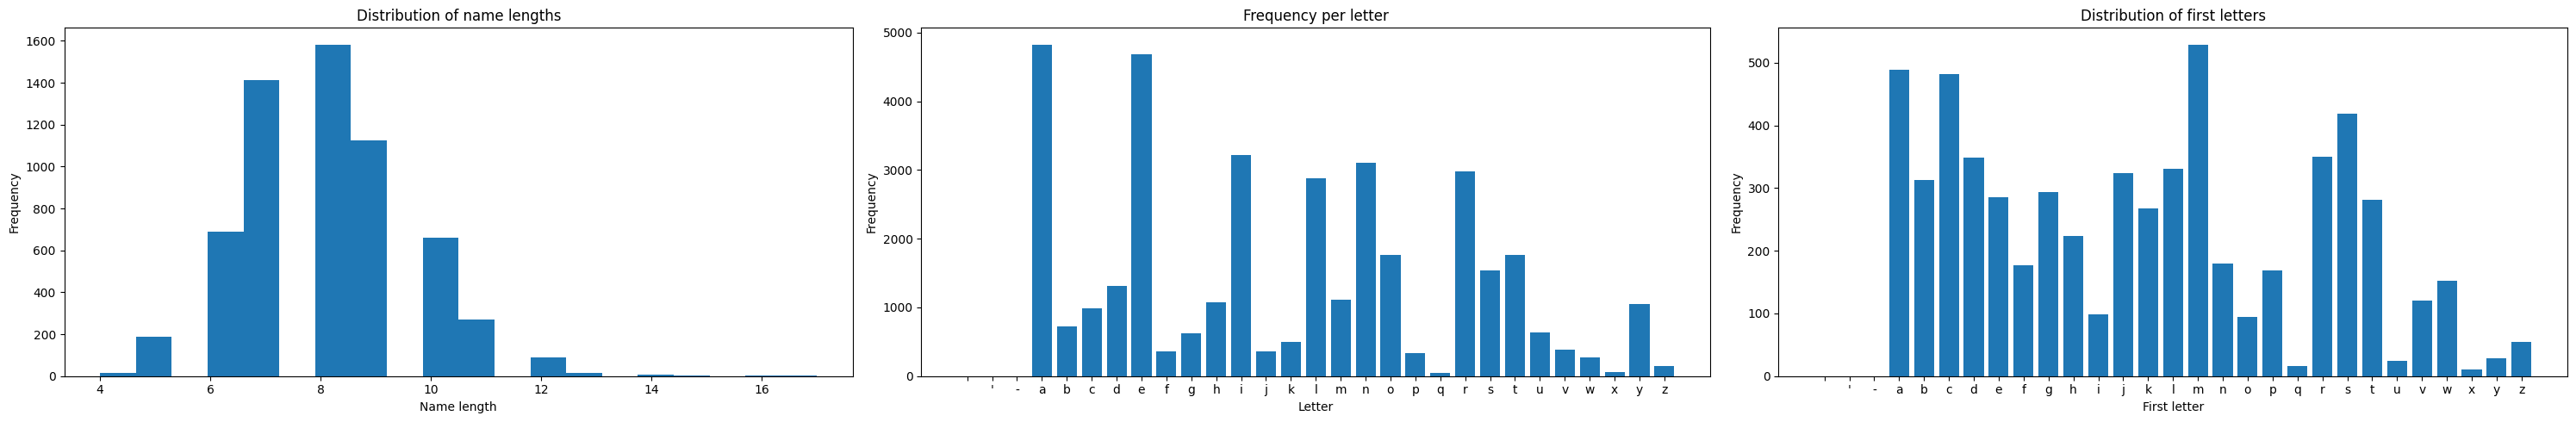

In [4]:
import matplotlib.pyplot as plt

# Plot the distribution of the names
plt.figure(figsize=(30, 5))

plt.subplot(1, 3, 1)
plt.title("Distribution of name lengths")
plt.hist([len(name) + 2 for name in train_names], bins=20) # +2 for <s> and </s>
plt.xlabel("Name length")
plt.ylabel("Frequency")


plt.subplot(1, 3, 2)
plt.title("Frequency per letter")
letter_freq = {letter: 0 for letter in vocab}
for name in train_names:
    for letter in name:
        if letter.isalpha():
            letter_freq[letter.lower()] += 1
        
plt.bar(letter_freq.keys(), letter_freq.values())
plt.xlabel("Letter")
plt.ylabel("Frequency")


plt.subplot(1, 3, 3)
plt.title("Distribution of first letters") # Ignoring <s>
first_letter_freq = {letter: 0 for letter in vocab}
for name in train_names:
    first_letter_freq[name[0]] += 1
plt.bar(first_letter_freq.keys(), first_letter_freq.values())

plt.xlabel("First letter")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


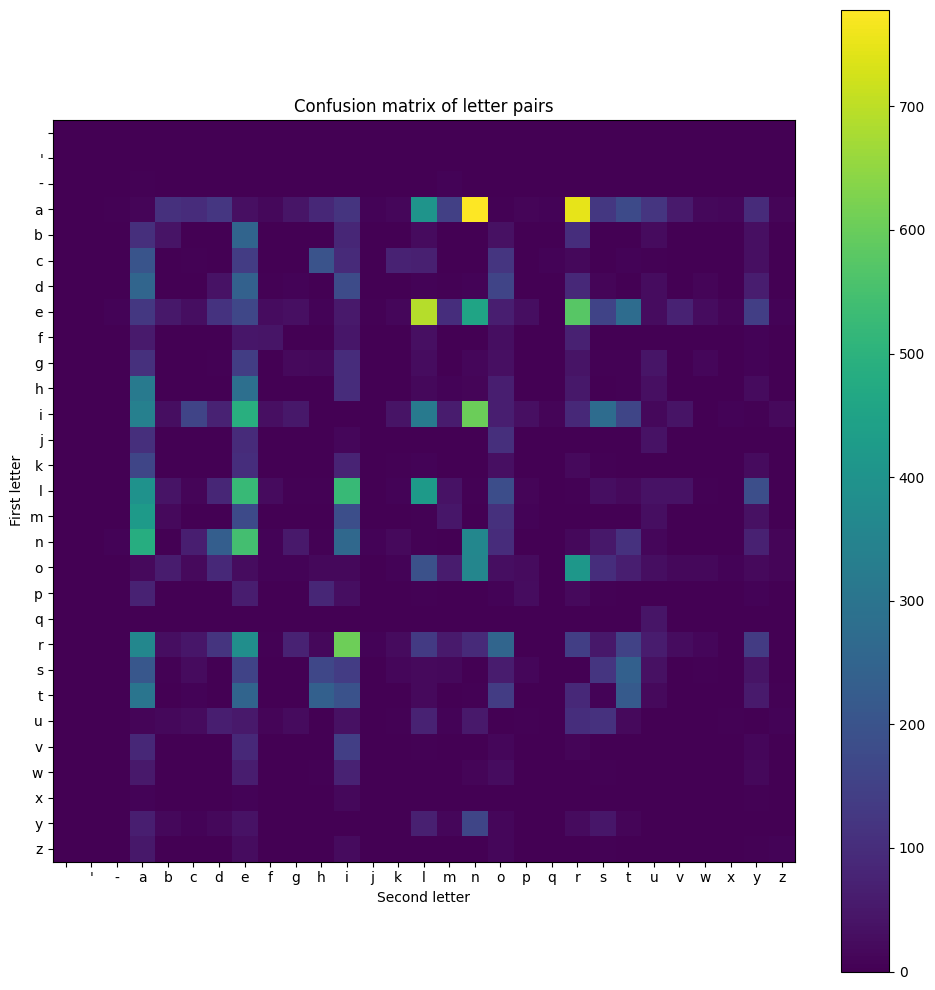

In [5]:
# Plot confunsion matrix of letter pairs
import numpy as np

letter_pairs = [a + b for a in vocab for b in vocab]
letter_pair_freq = {pair: 0 for pair in letter_pairs}
for name in train_names:
    for i in range(len(name) - 1):
        letter_pair_freq[name[i:i+2].lower()] += 1

confusion_matrix = np.zeros((len(vocab), len(vocab)))
for i, a in enumerate(vocab):
    for j, b in enumerate(vocab):
        confusion_matrix[i, j] = letter_pair_freq[a + b]

plt.figure(figsize=(10, 10))
plt.imshow(confusion_matrix)
plt.xticks(range(len(vocab)), vocab)
plt.yticks(range(len(vocab)), vocab)
plt.xlabel("Second letter")
plt.ylabel("First letter")
plt.title("Confusion matrix of letter pairs")
plt.colorbar()
plt.tight_layout()
plt.show()

## Training

In [6]:
device = "mps"

In [7]:
import torch
import torch.nn as nn
from ema_pytorch import EMA

### Encoded Corpus

In [8]:
# Add start and end tokens
vocab = ["</s>", "<pad>", "<unk>"] + vocab

In [9]:
seq_len = max(len(name) for name in train_names) + 2
print(f"Max sequence length: {seq_len}")

def pad_sequence(sequence: list[int], seq_len: int) -> list[int]:
    return sequence + [vocab.index("<pad>")] * (seq_len - len(sequence))

def encode_name(name: str) -> list[int]:
    result = []
    for letter in name.lower():
        if letter in vocab:
            result.append(vocab.index(letter))
        else:
            result.append(vocab.index("<unk>"))
    result.append(vocab.index("</s>"))
    return pad_sequence(result, seq_len)
    

def decode_name(name: list[int]) -> str:
    if vocab.index("</s>") in name:
        name.remove(vocab.index("</s>"))
    if vocab.index("<pad>") in name:
        name = [letter for letter in name if letter != vocab.index("<pad>")]

    name = "".join([vocab[letter] for letter in name])
    return name[0].upper() + name[1:]


print(encode_name("Alice"))
print(decode_name(encode_name("Alice")))

Max sequence length: 17
[6, 17, 14, 8, 10, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Alice


In [10]:
train_encoded_names = [encode_name(name) for name in train_names]
test_encoded_names = [encode_name(name) for name in test_names]

In [11]:
len(train_encoded_names), len(test_encoded_names)

(6063, 1516)

### Create Dataset and Loader

In [12]:
train_encoded_corpus = torch.Tensor(train_encoded_names).to(device)
test_encoded_corpus = torch.Tensor(test_encoded_names).to(device)

train_dataset = torch.utils.data.TensorDataset(train_encoded_corpus)
test_dataset = torch.utils.data.TensorDataset(test_encoded_corpus)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

### Helper functions

In [13]:
@torch.no_grad()
def validate(model):
    model.eval()
    total_loss = 0
    for x, in test_loader:
        inputs = x[:, :-1].long()
        targets = x[:, 1:].long()

        outputs, _ = model(inputs)

        loss = torch.nn.functional.cross_entropy(outputs.transpose(1, 2), targets)
        total_loss += loss.item()
        
    model.train()
    return total_loss / len(test_loader)

### RNN Model

In [16]:
class RNN(nn.Module):
    def __init__(
        self, vocab_size, hidden_size, num_layers, dropout=0.1, batch_first=True
    ):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.rnn = nn.RNN(
            hidden_size,
            hidden_size,
            num_layers,
            batch_first=batch_first,
            dropout=dropout,
        )
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, vocab_size),
        )

    def forward(self, x, hidden: torch.Tensor | None = None):
        if hidden is None:
            hidden = torch.zeros(
                self.rnn.num_layers, x.size(0), self.rnn.hidden_size, device=device
            )

        x = self.embedding(x)
        x, hidden = self.rnn(x, hidden)
        x = self.mlp(x)

        return x, hidden
    
    def forward_with_gradient(self, x, hidden=None):
        if hidden is None:
            hidden = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size, device=x.device)
        x = self.embedding(x)
        x, hidden = self.rnn(x, hidden)
        output = self.mlp(x)
        return output, hidden, x  # return embeddings for gradient computation


    def generate(
        self,
        start_seq: str | None = None,
        max_len: int = 20,
        hidden: torch.Tensor | None = None,
    ) -> str:
        if start_seq is None:
            start_seq = vocab[random.randint(4, len(vocab) - 1)]

        if hidden is None:
            hidden = torch.zeros(
                self.rnn.num_layers, 1, self.rnn.hidden_size, device=device
            )
        x = torch.tensor([[vocab.index(char) for char in start_seq]], device=device)

        output = [x.flatten()]
        for _ in range(max_len):
            x, hidden = self(x, hidden)
            if x.shape[1] > 1:
                x = x[:, -1:]

            x = x.softmax(dim=-1).argmax(dim=-1)
            if x.item() == vocab.index("</s>") and len(output) > 2:
                break
            output.append(x.flatten())
        return decode_name(torch.cat(output).flatten().tolist())


hidden_size = 128
num_layers = 8
dropout = 0.1

model = RNN(len(vocab), hidden_size, num_layers, dropout).to(device)

print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters")
model.generate()

Model has 288,928 parameters


'Z ac ca aa a   aa  ac'

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
ema = EMA(model, beta=0.999, update_after_step=100, update_every=1)

In [19]:
from tqdm import tqdm

In [20]:
# Train the model
for epoch in range(100):
    pbar = tqdm(train_loader, leave=True, desc=f"Epoch {epoch + 1:02d}")
    val_loss = validate(model)
    
    for batch in pbar:
        batch = batch[0].to(device)
        model.train()
        optimizer.zero_grad()

        inputs = batch[:, :-1].long()
        targets = batch[:, 1:].long()

        outputs, _ = model(inputs)

        loss = torch.nn.functional.cross_entropy(outputs.transpose(1, 2), targets)
        loss.backward()
        optimizer.step()

        pbar.set_postfix(loss=loss.item(), val_loss=val_loss)
        pbar.update()

        ema.update()

print("\n\nGenerated names:")
model.generate()

Epoch 100: 100%|██████████| 94/94 [00:05<00:00, 16.14it/s, loss=0.628, val_loss=0.703]




Generated names:


'Nell'

In [21]:
for _ in range(10):
    print(model.generate())

Frederick
Inge
-listania
'lena
Frederick
Willie
Bertina
Jonella
Oralia
Martie


In [22]:
torch.save(model.state_dict(), "blog/4-names/models/rnn.pth")

### LSTM

In [23]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers, dropout, batch_first=True):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, num_layers,dropout=dropout, batch_first=batch_first)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden: tuple[torch.Tensor, torch.Tensor] | None = None):
        if hidden is None:
            hidden = (
                torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size, device=x.device),
                torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size, device=x.device),
            )

        x = self.embedding(x)
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)

        return x, hidden

    def generate(
        self,
        start_seq: str | None = None,
        max_len: int = 20,
        hidden: tuple[torch.Tensor, torch.Tensor] | None = None,
    ) -> str:
        if start_seq is None:
            start_seq = vocab[random.randint(4, len(vocab) - 1)]

        if hidden is None:
            hidden = (
                torch.zeros(self.rnn.num_layers, 1, self.rnn.hidden_size, device=device),
                torch.zeros(self.rnn.num_layers, 1, self.rnn.hidden_size, device=device),
            )

        x = torch.tensor([[vocab.index(start_seq)]], device=device).long()

        output = [int(x.item())]
        for _ in range(max_len):
            x, hidden = self(x, hidden)
            x = x.softmax(dim=-1).argmax(dim=-1)
            output.append(x.item())
            if x.item() == vocab.index("</s>"):
                break

        return decode_name(output)


hidden_size = 128
num_layers = 8
dropout = 0.1

model = LSTM(len(vocab), hidden_size, num_layers, dropout).to(device)

print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters")
model.generate()

Model has 1,064,992 parameters


'E<unk><unk><unk><unk>yyy<unk><unk><unk><unk>sseeqqqqq'

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
ema = EMA(model, beta=0.999, update_after_step=100, update_every=1)

In [30]:
# Train the model
for epoch in range(100):
    pbar = tqdm(train_loader, leave=True, desc=f"Epoch {epoch + 1:02d}")
    val_loss = validate(model)
    
    for batch in pbar:
        batch = batch[0].to(device)
        model.train()
        optimizer.zero_grad()

        inputs = batch[:, :-1].long()
        targets = batch[:, 1:].long()

        outputs, _ = model(inputs)

        loss = torch.nn.functional.cross_entropy(outputs.transpose(1, 2), targets)
        loss.backward()
        optimizer.step()

        pbar.set_postfix(loss=loss.item(), val_loss=val_loss)
        pbar.update()

        # ema.update()

print("\n\nGenerated names:")
model.generate()

Epoch 100: 100%|██████████| 94/94 [00:01<00:00, 49.59it/s, loss=0.528, val_loss=0.777]




Generated names:


'Clllllssldlldsdsllod'

In [31]:
for _ in range(10):
    print(model.generate())

J
'
J
Hi
T
Vllddee
J
Mid
Clllllssldlldsdsllod
E


In [ ]:
torch.save(model.state_dict(), "blog/4-names/models/lstm.pth")

### GRU

In [ ]:
class GRU(nn.Module):
    def __init__(
        self, vocab_size, hidden_size, num_layers, dropout=0.1, batch_first=True
    ):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.gru = nn.GRU(
            hidden_size,
            hidden_size,
            num_layers,
            batch_first=batch_first,
            dropout=dropout,
        )
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, vocab_size),
        )

    def forward(self, x, hidden: torch.Tensor | None = None):
        if hidden is None:
            hidden = torch.zeros(
                self.gru.num_layers, x.size(0), self.gru.hidden_size, device=device
            )

        x = self.embedding(x)
        x, hidden = self.gru(x, hidden)
        x = self.mlp(x)

        return x, hidden
    
    def forward_with_gradient(self, x, hidden=None):
        if hidden is None:
            hidden = torch.zeros(self.gru.num_layers, x.size(0), self.gru.hidden_size, device=x.device)
        x = self.embedding(x)
        x, hidden = self.gru(x, hidden)
        output = self.mlp(x)
        return output, hidden, x  # return embeddings for gradient computation


    def generate(
        self,
        start_seq: str | None = None,
        max_len: int = 20,
        hidden: torch.Tensor | None = None,
    ) -> str:
        if start_seq is None:
            start_seq = vocab[random.randint(4, len(vocab) - 1)]

        if hidden is None:
            hidden = torch.zeros(
                self.gru.num_layers, 1, self.gru.hidden_size, device=device
            )
        print(start_seq)
        x = torch.tensor([[vocab.index(char) for char in start_seq]], device=device)

        output = [x.flatten()]
        for _ in range(max_len):
            x, hidden = self(x, hidden)
            if x.shape[1] > 1:
                x = x[:, -1:]

            x = x.softmax(dim=-1).argmax(dim=-1)
            if x.item() == vocab.index("</s>") and len(output) > 2:
                break
            output.append(x.flatten())
        return decode_name(torch.cat(output).flatten().tolist())


hidden_size = 128
num_layers = 8
dropout = 0.1

model = GRU(len(vocab), hidden_size, num_layers, dropout).to(device)

print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters")
model.generate()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
ema = EMA(model, beta=0.9999, update_after_step=100, update_every=1)

In [ ]:
# Train the model
for epoch in range(100):
    pbar = tqdm(train_loader, leave=True, desc=f"Epoch {epoch + 1:02d}")
    val_loss = validate(model)
    
    for batch in pbar:
        batch = batch[0].to(device)
        model.train()
        optimizer.zero_grad()

        inputs = batch[:, :-1].long()
        targets = batch[:, 1:].long()

        outputs, _ = model(inputs)

        loss = torch.nn.functional.cross_entropy(outputs.transpose(1, 2), targets)
        loss.backward()
        optimizer.step()

        pbar.set_postfix(loss=loss.item(), val_loss=val_loss)
        pbar.update()

        ema.update()

print("\n\nGenerated names:")
model.generate()

In [ ]:
for _ in range(10):
    print(model.generate())

In [ ]:
torch.save(model.state_dict(), "blog/4-names/models/gru.pth")